<a href="https://colab.research.google.com/github/steffen-mdv/steffen-mdv.github.io/blob/master/Corona.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
!pip install lmfit
from lmfit import Model, Parameters
import matplotlib.dates as dates

     |████████████████████████████████| 266kB 3.5MB/s 
     |████████████████████████████████| 61kB 10.0MB/s 
     |████████████████████████████████| 235kB 55.6MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.0-cp36-none-any.whl size=87917 sha256=8e9e7459adaaae0b6e1f6ac26bdc75f781127d38c1dedd08a7ba24ca06fd9d49
  Stored in directory: /root/.cache/pip/wheels/1f/93/e9/8d3f759e466f5bbfed3ba1d7dc5b3d4389c469a1ec9a2acaee
  Created wheel for asteval: filename=asteval-0.9.18-cp36-none-any.whl size=17381 sha256=ef1497ffb6f2a98b96a4da406be9a21cc481226de4c97e05d667a6c241469539
  Stored in directory: /root/.cache/pip/wheels/1c/53/1b/28d929700c9633b1786a4982e6db564ec8326a8930234dcc19
  Created wheel for uncertainties: filename=uncertainties-3.1.2-cp36-none-any.whl size=96456 sha256=fe887cb6f567f95201af69f89c99deff49aaa4a5177b07a5141a698617790ca3
  Stored in directory: /root/.cache/pip/wheels/d9/d3/0e/5b0b743a8abd50373705427438456da5dc2621891138d7a618
Successfully built lmfit asteval uncertaintie

In [0]:
# Read newest data from JHU
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
infections = pd.read_csv(url, error_bad_lines=False)
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
deaths = pd.read_csv(url, error_bad_lines=False)
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
recovered = pd.read_csv(url, error_bad_lines=False)
# Create data arrays
dateaxis = dates.datestr2num(infections.iloc[11, 33:].index)
days = np.arange(np.size(infections.iloc[11, 33:].values)).astype(np.float)
infectionval = infections.iloc[11, 33:].values
infectionvalI = infections.iloc[16, 33:].values
deathval = deaths.iloc[11, 33:].values
deathvalI = deaths.iloc[16, 33:].values
recoverval = recovered.iloc[11, 33:].values-recovered.iloc[11, 33]
recovervalI = recovered.iloc[16, 33:].values

In [0]:
# Define SIR Model
def SIRfun(P, t, beta, gamma, N):
    S, I, R = P
    dSdt = -beta*S*I/N
    dIdt = beta*S*I/N - gamma*I
    dRdt = gamma*I
    return [dSdt, dIdt, dRdt]

# Fit SIR Model
def fitfun(x, **p):
    ts = np.arange(np.max(x))
    f = lambda P, t: SIRfun(P, t, p['beta'], p['gamma'], p['N'])
    P0 = (p['N'], p['N0'], p['R0'])
    solution = odeint(f, P0, ts)
    return solution[-np.size(x):,1]

fitModel = Model(fitfun)
pars = Parameters()
pars.add('beta', value=0.2, min=0.00)
# Set recovery time to 2 weeks
pars.add('gamma', value=1/14, vary=False)
# Set N to ~ 70% of the population
pars.add('N', value=0.7*80e6, vary=False)
pars.add('N0', value=np.array(infectionval-deathval-recoverval)[0].astype(np.float), min=0, vary=True)
pars.add('R0', value = np.array(deathval+recoverval)[0].astype(np.float), min=0, vary=True)
res = fitModel.fit(np.array(infectionval-deathval-recoverval)[-10:].astype(np.float), x=np.array(days)[-10:], params=pars)
pars.add('beta', value=0.2, min=0.00)
pars.add('gamma', value=1/14, vary=False)
pars.add('N', value=0.7*60e6, vary=False)
pars.add('N0', value=np.array(infectionvalI-deathvalI-recovervalI)[0].astype(np.float), min=0, vary=True)
pars.add('R0', value = np.array(deathvalI+recovervalI)[0].astype(np.float), min=0, vary=True)
resI = fitModel.fit(np.array(infectionvalI-deathvalI-recovervalI)[-10:].astype(np.float), x=np.array(days)[-10:], params=pars)


Anzahl der Intensivstationsbetten: 5376.000000000001
Parameters([('beta', <Parameter 'beta', value=0.3309887918757535, bounds=[0.0:inf]>), ('gamma', <Parameter 'gamma', value=0.07142857142857142 (fixed), bounds=[-inf:inf]>), ('N', <Parameter 'N', value=56000000.0 (fixed), bounds=[-inf:inf]>), ('N0', <Parameter 'N0', value=14.255381008951783, bounds=[0:inf]>), ('R0', <Parameter 'R0', value=0.0, bounds=[0:inf]>)])


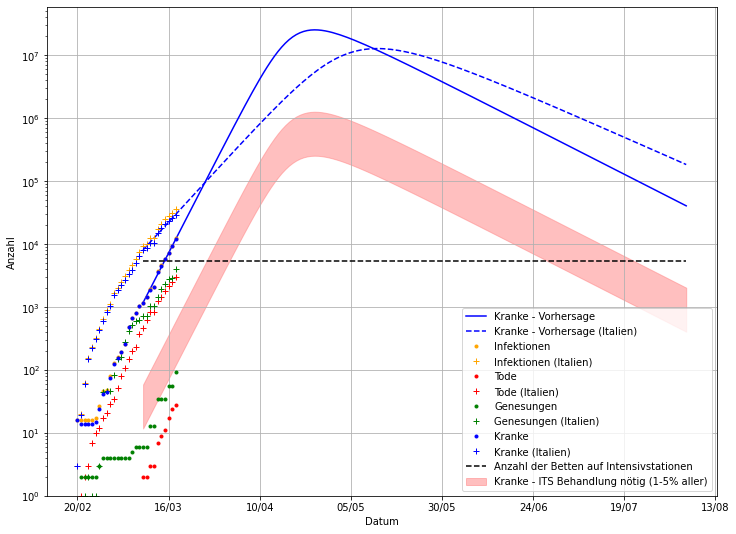

In [0]:
# Plot Data
fitvec = np.arange(150)+days[-10]
fitdatevec = np.arange(150)+ dateaxis[-10]
nBetten = 33.6/1e5*80e6*0.2
print("Anzahl der Intensivstationsbetten:", nBetten)
print(res.params)
fit = fitModel.eval(x=fitvec, params=res.params)
fitI = fitModel.eval(x=fitvec, params=resI.params)
pars = Parameters()
pars.add('beta', value=0.07, min=0.00)
pars.add('gamma', value=1/14, vary=False)
pars.add('N', value=0.7*80e6, vary=False)
pars.add('N0', value=1000, vary=True)
pars.add('R0', value=0, vary=False)

goodmodel = fitModel.eval(x=np.array(fitvec), params=pars)
plt.figure(figsize=(12,9))
plt.plot(fitdatevec, fit, 'b', label="Kranke - Vorhersage")
plt.plot(fitdatevec, fitI, 'b--', label="Kranke - Vorhersage (Italien)")

#plt.plot(fitdatevec, goodmodel, 'b--', label="Kranke - Ziel")
plt.fill_between(fitdatevec, 0.01*fit, 0.05*fit, label="Kranke - ITS Behandlung nötig (1-5% aller)", color=(1, 0.5, 0.5,0.5))
#plt.fill_between(fitdatevec, 0.01*goodmodel, 0.05*goodmodel, label="Kranke - ITS Behandlung nötig (1-5% aller)", color=(1, 0.9, 0.9, 0.5))



plt.plot(dateaxis, infectionval, '.', label="Infektionen", color='orange')
plt.plot(dateaxis, infectionvalI, '+', label="Infektionen (Italien)", color='orange')

plt.plot(dateaxis, deathval, 'r.', label="Tode")
plt.plot(dateaxis, deathvalI, 'r+', label="Tode (Italien)")

plt.plot(dateaxis, recoverval, 'g.', label="Genesungen")
plt.semilogy(dateaxis, recovervalI, 'g+', label="Genesungen (Italien)")

plt.plot(dateaxis, infectionval-deathval-recoverval, 'b.', label="Kranke")
plt.plot(dateaxis, infectionvalI-deathvalI-recovervalI, 'b+', label="Kranke (Italien)")

plt.gca().xaxis.set_major_formatter(dates.DateFormatter('%d/%m'))
plt.grid()


plt.plot((fitdatevec[0], fitdatevec[-1]),(nBetten, nBetten), 'k--', label="Anzahl der Betten auf Intensivstationen")
plt.legend()
plt.ylim(1,)
plt.xlabel("Datum")
plt.ylabel("Anzahl")
plt.savefig("Corona.pdf")

In [0]:
df=pd.read_csv("https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv")
df['Meldedatum'] = pd.to_datetime(df['Meldedatum'])

In [28]:
df

,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,IdLandkreis,Datenstand
0,3,Niedersachsen,LK Verden,A60-A79,M,2,0,173319,2020-03-20 00:00:00+00:00,3361,23.03.2020 00:00
1,3,Niedersachsen,LK Verden,A60-A79,W,1,0,173320,2020-03-14 00:00:00+00:00,3361,23.03.2020 00:00
2,3,Niedersachsen,SK Delmenhorst,A15-A34,M,1,0,173321,2020-03-16 00:00:00+00:00,3401,23.03.2020 00:00
3,3,Niedersachsen,SK Delmenhorst,A15-A34,M,1,0,173322,2020-03-19 00:00:00+00:00,3401,23.03.2020 00:00
4,3,Niedersachsen,SK Delmenhorst,A35-A59,M,1,0,173323,2020-02-04 00:00:00+00:00,3401,23.03.2020 00:00
...,...,...,...,...,...,...,...,...,...,...,...
10348,8,Baden-Württemberg,LK Göppingen,A60-A79,W,3,0,177314,2020-03-18 00:00:00+00:00,8117,23.03.2020 00:00
10349,8,Baden-Württemberg,LK Göppingen,A60-A79,W,2,0,177315,2020-03-19 00:00:00+00:00,8117,23.03.2020 00:00
10350,8,Baden-Württemberg,LK Göppingen,A80+,M,1,1,177316,2020-03-12 00:00:00+00:00,8117,23.03.2020 00:00
10351,8,Baden-Württemberg,LK Göppingen,A80+,M,1,0,177317,2020-03-18 00:00:00+00:00,8117,23.03.2020 00:00


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/tools.py:3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f576948a0f0>,
      dtype=object)

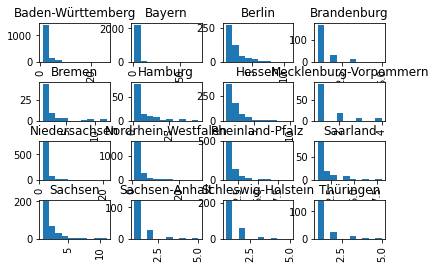

In [10]:
df.hist("AnzahlFall", by="Bundesland")

In [0]:
cases=df.groupby(['Meldedatum']).sum()['AnzahlFall']

In [36]:
cases.cumsum()

Meldedatum
2020-01-28 00:00:00+00:00        2
2020-01-29 00:00:00+00:00        4
2020-01-31 00:00:00+00:00        7
2020-02-03 00:00:00+00:00        8
2020-02-04 00:00:00+00:00       11
2020-02-06 00:00:00+00:00       12
2020-02-07 00:00:00+00:00       13
2020-02-11 00:00:00+00:00       15
2020-02-12 00:00:00+00:00       16
2020-02-25 00:00:00+00:00       18
2020-02-26 00:00:00+00:00       26
2020-02-27 00:00:00+00:00       47
2020-02-28 00:00:00+00:00       88
2020-02-29 00:00:00+00:00      108
2020-03-01 00:00:00+00:00      141
2020-03-02 00:00:00+00:00      181
2020-03-03 00:00:00+00:00      246
2020-03-04 00:00:00+00:00      388
2020-03-05 00:00:00+00:00      563
2020-03-06 00:00:00+00:00      733
2020-03-07 00:00:00+00:00      866
2020-03-08 00:00:00+00:00      951
2020-03-09 00:00:00+00:00     1274
2020-03-10 00:00:00+00:00     1829
2020-03-11 00:00:00+00:00     2528
2020-03-12 00:00:00+00:00     3453
2020-03-13 00:00:00+00:00     4790
2020-03-14 00:00:00+00:00     6032
2020-03-1

(10, 36158.701390901246)

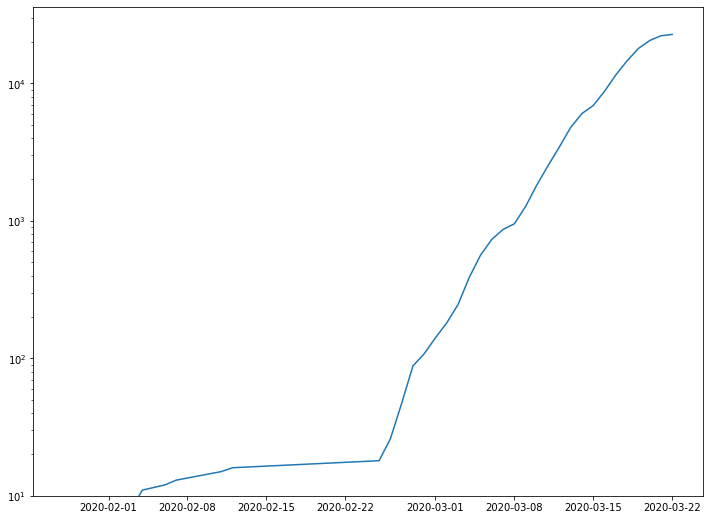

In [44]:
plt.figure(figsize=(12,9))
#plt.semilogy(cases)
plt.semilogy(cases.cumsum())
plt.ylim(10)
